# STAT 201 Project

## Group 11
Ray Tao    
Florence Wang    
Lesley Mai   
Harsha Chhetri

<hr style="opacity: 0.3" />

# Compare the delay rate of two popular airlines in the United States

## Introduction

### Basic Information

As the demand for fast-speed travel ascending rapidly, taking planes becomes one of the most popular choices during the past several decades. At the same time, flight delay is most depressing but also sometimes not avoidable. For instance, among different airlines, about 0% to 34% were delayed today (FlightAware, 2023). Therefore, the average delay rate of an airline has become an essential standard for customers to evaluate and choose a company. In this project, we will use the dataset created by Ulrik Thyge Pedersen (2023) to find if there's a significant difference in the delay rate between two industry giants, Delta Airlines and American Airlines.
### Research Question

Is there a difference between the delay rate of flights operated by Delta Airlines and American Airlines?



## Methods and Results

In this project, we plan to use two different methods to conduct a hypothesis test about the discrepancy between the proportion of delayed flights operated by Delta Airlines and American Airline. First, we will use the bootstrapping method in the infer package and then we plan to use the theory-based approach to perform a hypothesis test. We will also construct confidence intervals for the difference between the two proportions. We plan to conduct the hypothesis test at the most common significance level of $\alpha = 0.05$. In the bootstrapping approach, we will use permutation for the null model. For the theorem-based one, we will use Central Limit Theorem two sample z test.

Our null and alternative hypothesis is:

• $H_0 : p_1 = p_2$

• $H_a : p_1 ≠ p_2$

where:

$p_1$ is the proportion of delayed flights in all flights operated by Delta Airlines

$p_2$ is the proportion of delayed flights in all flights operated by American Airlines

Based on the sample proportions and the graph above, we expect to reject the null hypothesis and accept the alternative that the delay rate of these two airlines is different. There are various implications of this finding: for instance, it can help passengers to make a better choice when buying flight tickets and help invester to evaluate a airline company. Future research could delve into more categories of the airlines, even outside of simply the U.S., to provide information on different flight delays to a wider range of international travellers and to investigate what might be the causes of these differences.

Meanwhile, this analysis is limited because it does not tell us where this significant difference lies. We need to consider is there more test method that is more accurate to find the difference between two population other than Central Limit Theorem? 



In [71]:
library(tidyverse)
library(infer)
library(dplyr)
library(readr)
library(broom)
library(ggplot2)
library(cowplot)
set.seed(201)


### Load Data

In [72]:
airlines_delay <- read_csv("https://raw.githubusercontent.com/rayyyy122/STAT-201-Project/main/airlines_delay.csv")

Rows: 539382 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Airline, AirportFrom, AirportTo
dbl (5): Flight, Time, Length, DayOfWeek, Class

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Raw Dataset

In [73]:
head(airlines_delay)

Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
2313,1296,141,DL,ATL,HOU,1,0
6948,360,146,OO,COS,ORD,4,0
1247,1170,143,B6,BOS,CLT,3,0
31,1410,344,US,OGG,PHX,6,0
563,692,98,FL,BMI,ATL,4,0
3692,580,60,WN,MSY,BHM,4,0


<left><em>Table 1: Raw Airlines Delay Dataset</em></left>

### Clean and Wrangle Data

To clean and wrangle our data, we are going to:

1. Select the relevant columns for our question

2. Filter out rows containing `NA`

Since our original data has more than 100000 rows of observations, which makes bootstrapping operations run very slowly, we use `rep_sample_n` to draw a random sample from our data with a size of 2000.
 

In [74]:
# clean and wrangle data
delay <- airlines_delay |> 
    filter(Airline %in% c("DL", "AA")) |> 
    rename(Delay = Class) |>
    filter(!is.na(Airline)) |> 
    filter(!is.na(Delay)) |>
    mutate(Delay = as.factor(Delay)) |> # 0 means not Delayed
    select(c(Airline, Delay))

# randomly draw a sample with size of 2000
delay_data <- delay |>
    rep_sample_n(reps = 1, size = 2000)

head(delay_data) 


     

replicate,Airline,Delay
<int>,<chr>,<fct>
1,DL,0
1,DL,0
1,AA,1
1,AA,0
1,DL,1
1,DL,0


<left><em>Table 2: DL Airline and AA Airline Delay or Not </em></left>

### Broad Overview of Data

In this section, we will compute the estimates of the parameter "proportion" of delayed flights for each airline first, and plot the relevant data. We used different colors for delayed flights and proper flights to observe the difference more clearly.

In [75]:
# Compute the estimates of the parameter
delay_data_summary <- delay_data %>%
    group_by(Airline, Delay) %>%
    summarize(count = n()) %>%
    group_by(Airline) %>%
    mutate(total = sum(count),
         proportion = count/total)

delay_data_summary


# calculate observed test statistic
obs_diff_prop <- delay_data |> 
    specify(Delay ~ Airline, success = "1") |> 
    calculate(stat = "diff in props", order = c("DL", "AA")) |>
    rename(observed_test_stat = stat)

obs_diff_prop

`summarise()` has grouped output by 'Airline'. You can override using the
`.groups` argument.


Airline,Delay,count,total,proportion
<chr>,<fct>,<int>,<int>,<dbl>
AA,0,534,849,0.6289753
AA,1,315,849,0.3710247
DL,0,615,1151,0.5343180
DL,1,536,1151,0.4656820


observed_test_stat
<dbl>
0.09465728


We create two visualizations of the data: one displays the count of delayed versus not delayed flights of each airline, and another shows the proportion of delayed versus not delayed flights of each airline.

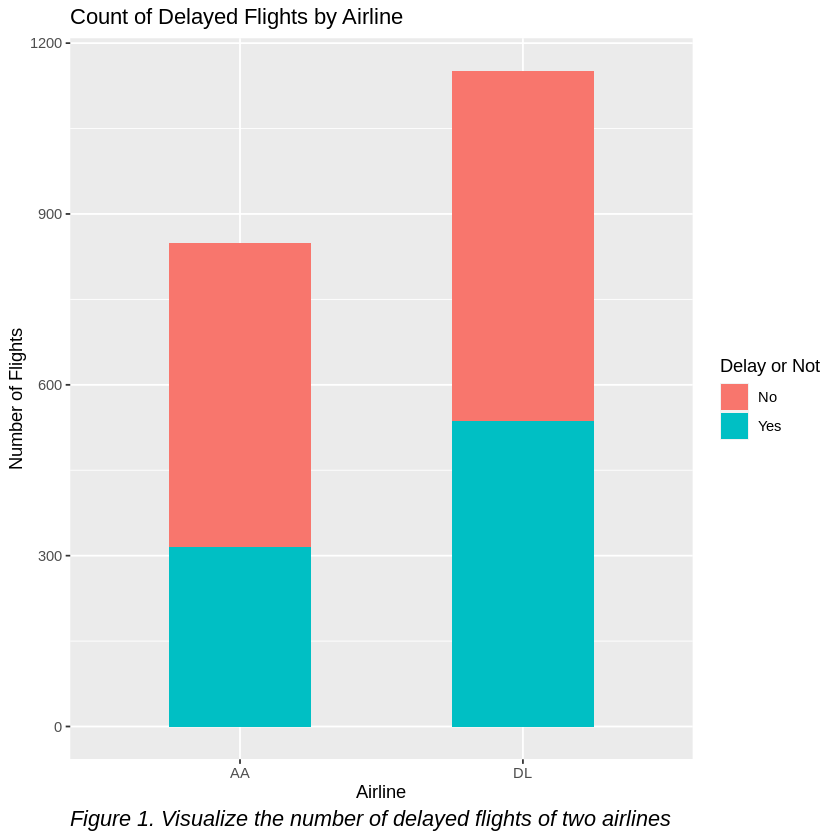

In [76]:
plot <- delay_data %>%
    ggplot(aes(x = Airline, fill = Delay)) +
    geom_bar(width = 0.5) +
    ggtitle("Count of Delayed Flights by Airline") +
    labs(y = "Number of Flights", caption = "Figure 1. Visualize the number of delayed flights of two airlines") +
    theme(plot.caption = element_text(size = 13, color = "black", hjust = 0, face = "italic")) +
    scale_fill_discrete(name = "Delay or Not",
                          breaks = c("0", "1"),
                          labels = c("No", "Yes")) 
plot

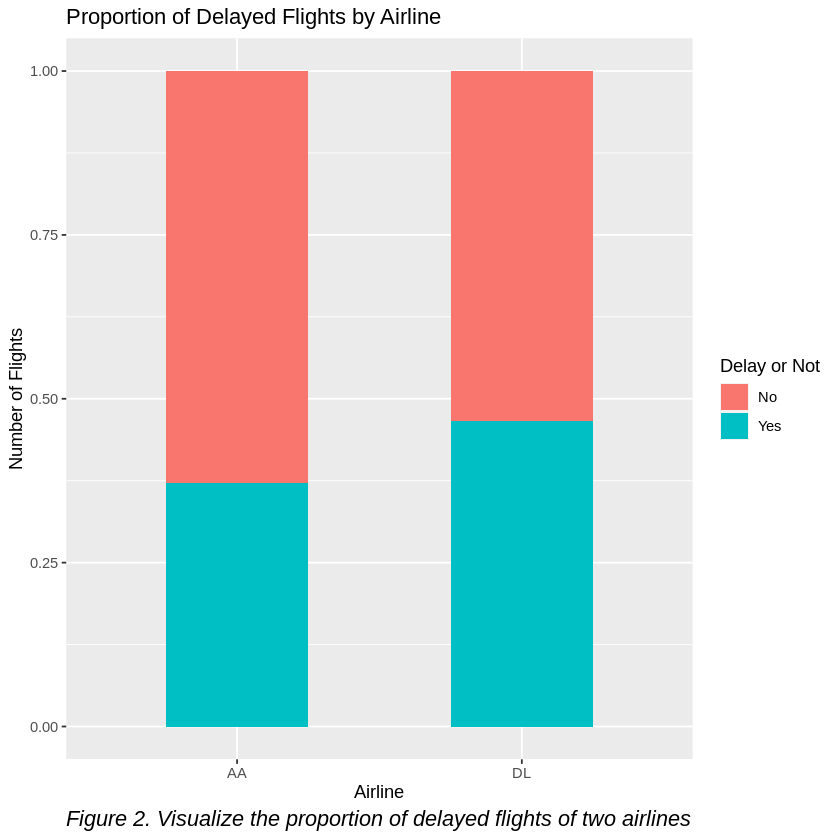

In [77]:
plot2 <- delay_data %>%
    ggplot(aes(x = Airline, fill = Delay)) +
    geom_bar(width = 0.5, position = "fill") +
    ggtitle("Proportion of Delayed Flights by Airline") +
    labs(y = "Number of Flights", caption = "Figure 2. Visualize the proportion of delayed flights of two airlines") +
    theme(plot.caption = element_text(size = 13, color = "black", hjust = 0, face = "italic")) +
    scale_fill_discrete(name = "Delay or Not",
                          breaks = c("0", "1"),
                          labels = c("No", "Yes")) 


plot2

## Hypothesis test via bootstrapping method

We applied boostrapping asymptotic method in the `infer` package to create the null model. 

In [78]:
# create the null model
null_distribution <- delay_data |> 
    specify(formula = Delay ~ Airline, success = "1") |> 
    hypothesize(null = "independence") |> 
    generate(reps = 500, type = "permute") |> 
    calculate(stat = "diff in props", order = c("DL", "AA"))

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


p_value
<dbl>
0


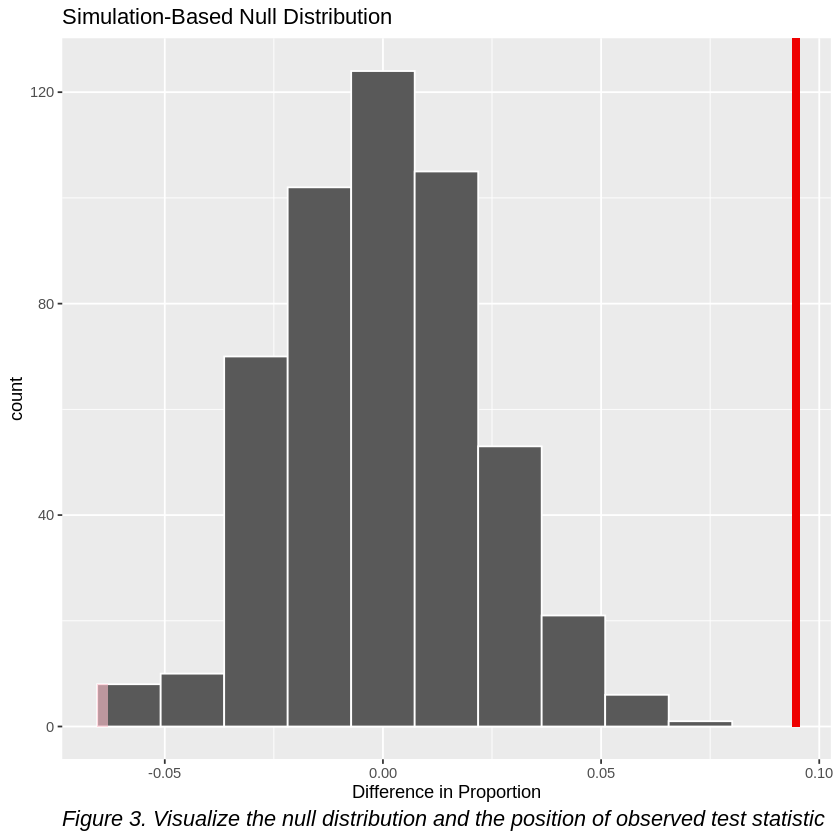

In [79]:
# visualize the null model and the position of observed test statistic
visualize(null_distribution, bins = 10) +
    shade_p_value(obs_stat = obs_diff_prop, direction = "both") +
    labs(x = "Difference in Proportion", caption = "Figure 3. Visualize the null distribution and the position of observed test statistic") +
    theme(plot.caption = element_text(size = 13, color = "black", hjust = 0, face = "italic")) 

# calculate the P-value
get_p_value(null_distribution, obs_stat = obs_diff_prop, direction = "both")

We then created the bootstrapping model, calculated the 95% confidence interval and visuallized the model shaded with the range of the confidence interval.

lower_ci,upper_ci
<dbl>,<dbl>
0.05309204,0.1362225


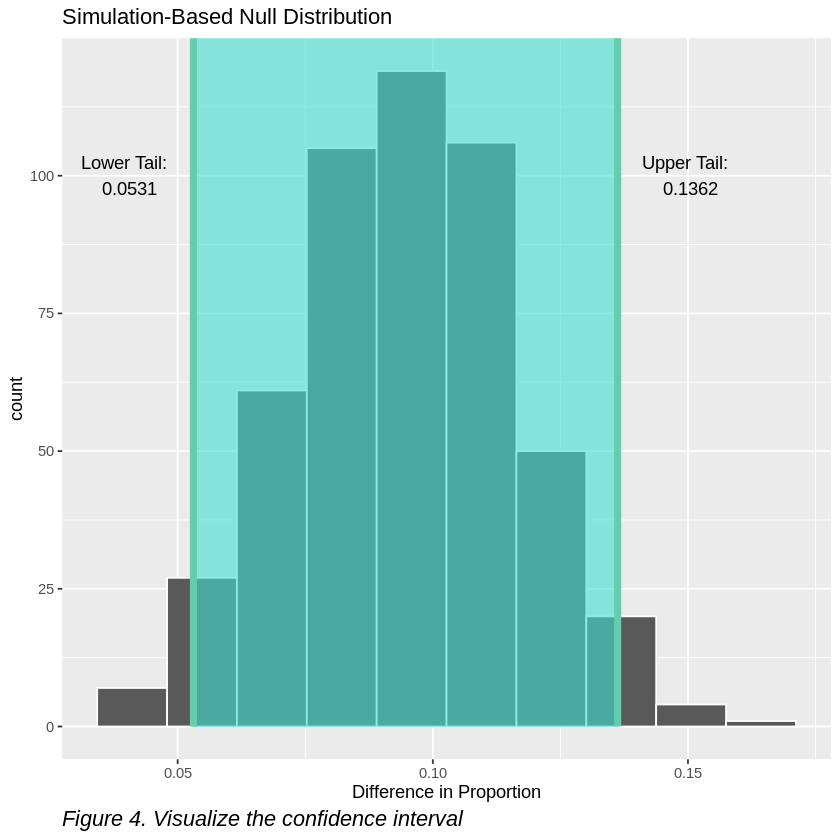

In [80]:
# calculate the 95% confidence interval
bootstrap_distribution <- delay_data |> 
    specify(formula = Delay ~ Airline, success = "1") |> 
    hypothesize(null = "independence") |> 
    generate(reps = 500, type = "bootstrap") |> 
    calculate(stat = "diff in props", order = c("DL", "AA"))

ci <- bootstrap_distribution |>
    get_confidence_interval(type = "se", point_estimate = obs_diff_prop, level = 0.95)
ci

# visualize the confidence interval
ci_plot <- visualize(bootstrap_distribution, bins = 10) +
    shade_confidence_interval(endpoints = ci) + 
    labs(x = "Difference in Proportion", caption = "Figure 4. Visualize the confidence interval") +
    annotate("text", x = 0.15, y = 100, label = "Upper Tail: \n 0.1362") +
    annotate("text", x = 0.04, y = 100, label = "Lower Tail: \n 0.0531") +
    theme(plot.caption = element_text(size = 13, color = "black", hjust = 0, face = "italic")) 
ci_plot 

### Result

First, we notice that the p-value is equal to 0 and the position of the test statistic covers none of the observations in the null distribution. Based on these two discoveries, we decided to reject the null hypothesis at a common 95% significance level. In other words, we believe that there exists a difference between the proportion of delayed flights operated by Delta Airlines versus American Airlines.

## Hypothesis test via theorey based approach

• $H_0 : p_1 = p_2$

• $H_a : p_1 ≠ p_2$

test statistic = $\frac{\hat{p_1} - \hat{p_2}} {\sqrt{\hat{p}(1 - \hat{p})(\frac{1} {n_1} + \frac{1} {n_2})}}$

where $\hat{p} = \frac{n_1\hat{p_1} + n_2\hat{p_2}} {n_1 + n_2}$

$\hat{p_1}$ : the proportion of delayed flights operated by Delta Airlines

$\hat{p_2}$ : the proportion of delayed flights operated by American Airlines

$n_1$ : the number of flights operated by Delta Airlines in the sample 

$n_2$ : the number of flights operated by American Airlines in the sample 

In [81]:
n1 <- sum(delay_data$Airline == "DL")
n2 <- sum(delay_data$Airline == "AA")
phat1 <- sum(delay_data$Airline == "DL" & delay_data$Delay == "1") / n1
phat2 <- sum(delay_data$Airline == "AA" & delay_data$Delay == "1") / n2

# perform the hypothesis test 
result <- tidy(
            prop.test(
                x = c(n1 * phat1, n2 * phat2),
                n = c(n1, n2),
                correct = FALSE))

result

estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.465682,0.3710247,17.90901,2.317221e-05,1,0.05122516,0.1380894,2-sample test for equality of proportions without continuity correction,two.sided


### Result

From the tidy output of the theory-based hypothesis test, we can see that the P value is 2.317e-05 which is much less that the significance level of 0.05. So we can reject the null hypothesis that there is no difference between the proportion of delayed flights between Delta Airlines and American Airlines. To be more specific, we'd like to accept the alternative hypothesis that there exists an obvious difference between them.

### Comparison between these two methods 

Based on the two result section above, we can see that both methods give very similar results: we reject the null hypothesis that the proportions of delayed flights operated by Delta and American Airlines are identical according to the small p-value vs the common 95% significance level. Though all the assumptions of the two methods are satisfied in this study, we may prefer the theory-based approach since it gives a p-value of 2.317e-05 while the bootstrapping method outputs a p-value of 0. The P-value of 0 gives the "perfect" rejection of the null hypothesis, which seems to be not really meaningful and reasonable.

## Discussion

In this project, our research question is Is there a difference between the delay rate of flights operated by Delta Airlines and American Airlines? We figured out this concern by performing hypothesis testing on the proportion of delayed flights operated by each of these two world-famous airlines. To make the result more plausible, we apply two types of methods. For the bootstrapping method, the sample we drew randomly from the dataset contains 2000 flights in the whole of America, which is representative and ensures bootstrapping works well. For the theory-based one, we carefully checked that both $n*p$ and $n*(1-p)$ are larger than 10, which means the Central Limit Theorem is satisfied. Hence the theory-based approach should also work well. 

After conducting hypothesis tests via different methods with some visualizations as well as computing statistical decision threshold values, we get quite similar preliminary results. As mentioned above, we find there's a significant difference between the delay rate of flights operated by Delta Airlines and American Airlines. This is what we expected at the beginning of this study. Because in reality, the delay rate is a pretty crucial standard when evaluating an airline company. Whether a flight delay or not can reflect much information, such as the efficiency of management, the force of supervision, etc.

Convincing as this research is, we merely focused on the different delayed rates of the two airlines, without consideration of other relevant factors. Therefore, there exists a bunch of limitations regarding our study and customer may not be able to judge an airline company solely based on our study. In the future, this study can lead to more concerns. One of them can be the relationship between the difference in delayed flights in terms of certain routes. Will Delta Airlines perform better than American Airlines on certain routes or vice versa? Further, limited by time and resources, we mainly concentrated on these two aviation giants. Questions regarding the delayed rate of other Airlines in the U.S. or even the whole world may arise. 

## Reference

1. FlightAware (2023). https://flightaware.com/live/cancelled/

2. Pedersen, U. T. (2023).Airlines Delay. https://www.kaggle.com/datasets/ulrikthygepedersen/airlines-delay